# Calibration
inspired by: http://jasss.soc.surrey.ac.uk/17/3/11.html

In [31]:
%matplotlib inline
import math
import numpy as np
import numpy.random as nrand
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import scipy.stats as stats
import powerlaw
from stockmarket import baselinemodel
from tqdm import tqdm
from pandas_datareader import data
from pylab import plot, show
from math import isclose
from stockmarket.stylizedfacts import *
import itertools
import quandl

# Import SPY data

### Prices

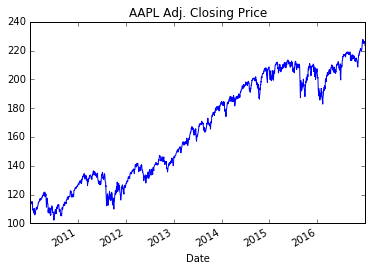

In [21]:
start_date = '2010-01-01'
end_date = '2016-12-31'

spy = data.DataReader("SPY", 
                       start=start_date, 
                       end=end_date, 
                       data_source='google')['Close']

spy.plot(title='AAPL Adj. Closing Price')

### Returns

In [22]:
returns = aapl.pct_change()
((1 + returns).cumprod() - 1).plot(title='SPY Cumulative Returns')

NameError: name 'aapl' is not defined

### Price to earnings

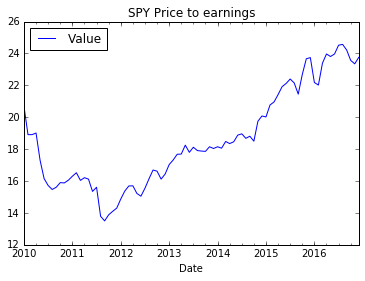

In [23]:
price_to_earning = quandl.get("MULTPL/SP500_PE_RATIO_MONTH", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
price_to_earning.plot(title='SPY Price to earnings')

## Calibrate agent_price_to_earnings_window with S&P 500 data

In [24]:
init_price_to_earnings_window = {}
price_to_earnings_descriptives = price_to_earning.describe()
init_price_to_earnings_window['lower_min'] = int(price_to_earnings_descriptives.loc['min']['Value'])
init_price_to_earnings_window['upper_min'] = int(price_to_earnings_descriptives.loc['25%']['Value'])

init_price_to_earnings_window['lower_max'] = int(price_to_earnings_descriptives.loc['75%']['Value'])
init_price_to_earnings_window['upper_max'] = int(price_to_earnings_descriptives.loc['max']['Value'])

init_price_to_earnings_window

{'lower_max': 21, 'lower_min': 13, 'upper_max': 24, 'upper_min': 16}

# 1 Calibrate zero intelligence benchmark to S&P 500 data

First we determine the value of money, initial profit and the discount rate by minimising the distance to the price to average price to earnings ratio observed in the S&P 500. 

| Parameter | Values |
| -------------| ------------|
| initial_total_money       | 13000 - 23000       |
| initial_profit       | 1000 - 10000    |
| discount_rate       | 0.01 - 0.25       |


$pricetoearningscriteria(x)=\left\{\begin{array}{cl}(\frac{av - x}{av})^2 & \quad \textrm{if} \quad\  lowerx < x < upperx,\\
0 &\quad \textrm{otherwise}\quad\\\
\end{array}\right.,$

In [51]:
# Full factorial design for: 
initial_total_money = [x for x in range(26000, 33000, 2000)]
initial_profit = [x for x in range(1000, 10000, 2000)]
discount_rate = [x / 100 for x in range(1, 25, 2)]
factors = list(itertools.product(initial_total_money, initial_profit, discount_rate))

In [52]:
factors

[(26000, 1000, 0.01),
 (26000, 1000, 0.03),
 (26000, 1000, 0.05),
 (26000, 1000, 0.07),
 (26000, 1000, 0.09),
 (26000, 1000, 0.11),
 (26000, 1000, 0.13),
 (26000, 1000, 0.15),
 (26000, 1000, 0.17),
 (26000, 1000, 0.19),
 (26000, 1000, 0.21),
 (26000, 1000, 0.23),
 (26000, 3000, 0.01),
 (26000, 3000, 0.03),
 (26000, 3000, 0.05),
 (26000, 3000, 0.07),
 (26000, 3000, 0.09),
 (26000, 3000, 0.11),
 (26000, 3000, 0.13),
 (26000, 3000, 0.15),
 (26000, 3000, 0.17),
 (26000, 3000, 0.19),
 (26000, 3000, 0.21),
 (26000, 3000, 0.23),
 (26000, 5000, 0.01),
 (26000, 5000, 0.03),
 (26000, 5000, 0.05),
 (26000, 5000, 0.07),
 (26000, 5000, 0.09),
 (26000, 5000, 0.11),
 (26000, 5000, 0.13),
 (26000, 5000, 0.15),
 (26000, 5000, 0.17),
 (26000, 5000, 0.19),
 (26000, 5000, 0.21),
 (26000, 5000, 0.23),
 (26000, 7000, 0.01),
 (26000, 7000, 0.03),
 (26000, 7000, 0.05),
 (26000, 7000, 0.07),
 (26000, 7000, 0.09),
 (26000, 7000, 0.11),
 (26000, 7000, 0.13),
 (26000, 7000, 0.15),
 (26000, 7000, 0.17),
 (26000, 7

In [53]:
# calculate the observed price to earnings
observed_average_price_to_earnings = price_to_earnings_descriptives.loc['mean']['Value']
observed_average_price_to_earnings

18.598928571428576

In [54]:
def calcute_cost(average_price_to_earnings, upper_bound, lower_bound, observed_average):
    """cost function for deviation from observed price to earnings ratio"""
    if (average_price_to_earnings < upper_bound) and (average_price_to_earnings > lower_bound):
        return ((observed_average - average_price_to_earnings) / observed_average)**2
    else:
        return 0

In [55]:
results = {}
# for every parameter possibility:
for idx, parameters in tqdm(enumerate(factors)):
    # 1 simulate model
    agents, firms, stocks, order_books = baselinemodel.stockMarketSimulation(seed=0,
                                                                             simulation_time=100,
                                                                         init_backward_simulated_time=200,
                                                                         number_of_agents=1000,
                                                                         share_chartists=0.0,
                                                                         share_mean_reversion=0.5,
                                                                         amount_of_firms=1,
                                                                         initial_total_money=(parameters[0],parameters[0]*1.1),
                                                                         initial_profit=(parameters[1], parameters[1]),
                                                                         discount_rate=parameters[2],
                                                                         init_price_to_earnings_window=((init_price_to_earnings_window['lower_min'],
                                                                                                         init_price_to_earnings_window['upper_min']),
                                                                                                        (init_price_to_earnings_window['lower_max'] ,
                                                                                                         init_price_to_earnings_window['upper_max'])),
                                                                         order_expiration_time=200,
                                                                         agent_order_price_variability=(1,1),
                                                                         agent_order_variability=1.5,
                                                                         agent_ma_short=(20, 40),
                                                                         agent_ma_long=(120, 150),
                                                                         agents_hold_thresholds=(0.9995, 1.0005),
                                                                         agent_volume_risk_aversion=0.1,
                                                                         agent_propensity_to_switch=1.1,
                                                                         firm_profit_mu=0.058,
                                                                         firm_profit_delta=0.00396825396,
                                                                         firm_profit_sigma=0.125,
                                                                         profit_announcement_working_days=20,
                                                                         printProgress=False,
                                                                         )
    # 2 extract average price to earnings ratio
    average_price_to_earnings = np.mean(stocks[0].price_to_earnings_history)
    # 3 calculate costs
    cost = calcute_cost(average_price_to_earnings, 
                        init_price_to_earnings_window['lower_max'], 
                        init_price_to_earnings_window['upper_min'],
                        observed_average_price_to_earnings)
    # 4 save costs with parameter pair 
    results[str(idx)] = (cost, average_price_to_earnings)

240it [44:38, 10.67s/it]


In [56]:
results

{'0': (0.0023187167062153099, 17.703333340913677),
 '1': (0.015485199905869678, 16.284486396435597),
 '10': (0.00041335402449926904, 18.97706542982759),
 '100': (0, 2.6123577997277865),
 '101': (0, 2.5551873809789494),
 '102': (0, 2.5433140586525558),
 '103': (0, 2.5445684024103441),
 '104': (0, 2.5319386167142657),
 '105': (0, 2.548120918646942),
 '106': (0, 2.5058545901822216),
 '107': (0, 2.5008135228629338),
 '108': (0, 2.8414781441170804),
 '109': (0, 2.4245385126721235),
 '11': (8.8280725588190851e-05, 18.773680055852434),
 '110': (0, 2.2697729066258159),
 '111': (0, 2.1588246363222252),
 '112': (0, 2.1143949039063448),
 '113': (0, 2.0678346292715428),
 '114': (0, 2.032584806654735),
 '115': (0, 2.0096945501145123),
 '116': (0, 1.9996470715866344),
 '117': (0, 1.995040927078173),
 '118': (0, 1.9786069169929994),
 '119': (0, 1.967329576062256),
 '12': (0, 6.7840093290658352),
 '120': (0.010716751079603236, 20.524322057634237),
 '121': (0.0014404544610153623, 19.304819649844521),
 

### Find non-zero results

In [62]:
# find the smallest non-zero cost 
# first delete all entries for which the first element is zero
non_zero_results = {}
for key in results:
    if results[key][0] != 0:
        non_zero_results[key] = results[key][0]
#non_zero_results
# then find the key of the smallest value

## Find the smallest error

In [64]:
calibrated_parameters_location = min(non_zero_results, key=non_zero_results.get)

# The parameter values are:

In [66]:
factors[int(calibrated_parameters_location)]

(26000, 1000, 0.17)

In [29]:
agents, firms, stocks, order_books = baselinemodel.stockMarketSimulation(seed=0,
                                                                         simulation_time=100,
                                                                         init_backward_simulated_time=200,
                                                                         number_of_agents=1000,
                                                                         share_chartists=0.0,
                                                                         share_mean_reversion=0.5,
                                                                         amount_of_firms=1,
                                                                         initial_total_money=(13000,15000),
                                                                         initial_profit=(1000, 1000),
                                                                         discount_rate=0.11,
                                                                         init_price_to_earnings_window=((4, 7), (10, 14)),
                                                                         order_expiration_time=200,
                                                                         agent_order_price_variability=(1,1),
                                                                         agent_order_variability=1.5,
                                                                         agent_ma_short=(20, 40),
                                                                         agent_ma_long=(120, 150),
                                                                         agents_hold_thresholds=(0.9995, 1.0005),
                                                                         agent_volume_risk_aversion=0.1,
                                                                         agent_propensity_to_switch=1.1,
                                                                         firm_profit_mu=0.058,
                                                                         firm_profit_delta=0.00396825396,
                                                                         firm_profit_sigma=0.125,
                                                                         profit_announcement_working_days=20,
                                                                         printProgress=False,
                                                                         )

In [37]:
# 2 extract average price to earnings ratio
average_price_to_earnings = np.mean(stocks[0].price_to_earnings_history)

In [45]:
# 3 calculate costs
cost = calcute_cost(average_price_to_earnings, 
                    init_price_to_earnings_window['lower_max'], 
             init_price_to_earnings_window['upper_min'],
            observed_average_price_to_earnings)

0.00046501567949725983

In [ ]:

results = {}
# 4 save costs with parameter pair 
results[str(idx)] = cost

# Calibration to SPY values





In [12]:
# determine parameter space
speculators = {'exp1': 10, 'exp2': 30, 'exp3': 50, 'exp4': 80} 
# for the parameters
results = {}

for key, n_speculators in sorted(speculators.items()):
    #print (key, n_speculators)
    # simulate the model
    print ('now starting ', key)
    agents, firms, stocks, order_books = baselinemodel.stockMarketSimulation(seed=0, simulation_time=1200,
                                                                                       amount_momentum=speculators[key],
                                                                                       amount_mean_reversion=speculators[key],
                                                                                       amount_noise_traders=200-speculators[key]*2,
                                                                                       amount_firms=1,
                                                                                       initial_money=(15, 19),
                                                                                       initial_bid_ask=(1,1),
                                                                                       initial_ma_short=(20,40),
                                                                                       initial_ma_long=(120,150),
                                                                                       initial_profit=(200,200),
                                                                                       initial_book_value=(10000, 10000),
                                                                                       initial_stock_amount=4000,
                                                                                       order_expiration_time=150,
                                                                                       init_propensity_to_switch=1.1,
                                                                                       init_price_to_earnings_window=((4, 7), (10, 14)),
                                                                                       firm_profit_mu=0.058,
                                                                                       firm_profit_delta=0.00396825396,
                                                                                       firm_profit_sigma=0.125,
                                                                                       profit_announcement_working_days=20,
                                                                                       agents_hold_thresholds=(0.9995, 1.0005),
                                                                                       init_backward_simulated_time=200,
                                                                                       trader_volume_risk_aversion=0.1,
                                                                                       order_variability=1.5,
                                                                                       printProgress=False
                                                                                       )
    # Apply the tests 
    # apply all tests to the model 
    # test 1
    first_test = zero_autocorrelation(calculate_returns(order_books[0].transaction_prices_history), 25)
    # test 2
    second_test = fat_tails(calculate_returns(order_books[0].transaction_prices_history))
    # test 3
    third_test = clustered_volatility(calculate_returns(order_books[0].transaction_prices_history), 25)
    # test 4
    fourth_test = long_memory(calculate_returns(order_books[0].transaction_prices_history), hurst, 2, 20)
    # save parameter space and test results
    results[key] = [first_test, second_test, third_test, fourth_test]

results

now starting  exp1
day is  600
day is 

Calculating best minimal value for power law fit
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:1138: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:1157: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:698: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


 1000
3.61016649072
0.0224431284521
h =  -0.0255297320862
now starting  exp2
day is  600
day is 

C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit

 1000
4.30906493971
0.0169788038241
h =  -0.0303327000604
now starting  exp3
day is  600
day is 


Calculating best minimal value for power law fit

 1000
4.85644574007
0.0709521445173
h =  -0.0190424372784
now starting  exp4
day is  600
day is 


Calculating best minimal value for power law fit

 1000
3.61406868557
0.040750717532
h =  -0.0318050368419


{'exp1': [True, True, False, True],
 'exp2': [True, True, False, True],
 'exp3': [True, True, False, True],
 'exp4': [True, True, False, True]}